In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

In [3]:
# Fetch Historical Data
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2024-01-01', interval='1d')
data = data[['Close']]  # Use only the 'Close' price for simplicity

[*********************100%***********************]  1 of 1 completed


In [4]:
# Data Preprocessing
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 60  # Using 60 days of data to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Reshape X to be 3D [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [5]:
# Define the RNN Model
model = Sequential([
    SimpleRNN(50, activation='tanh', return_sequences=False, input_shape=(seq_length, 1)),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/home/oem/Documents/github/magnimind_hw/magenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0460 - val_loss: 0.0055
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.5067e-04 - val_loss: 0.0025
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.8973e-04 - val_loss: 0.0020
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.1190e-04 - val_loss: 0.0015
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.7253e-04 - val_loss: 0.0011
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.8374e-04 - val_loss: 0.0014
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.1287e-04 - val_loss: 9.8131e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3139e-04 - val_loss: 9.6683e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0849e-04 - val_loss: 8.7906e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4844e-04 - val_loss: 9.9601e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1121e-04 - val_loss: 8.1198e-04
Epo

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


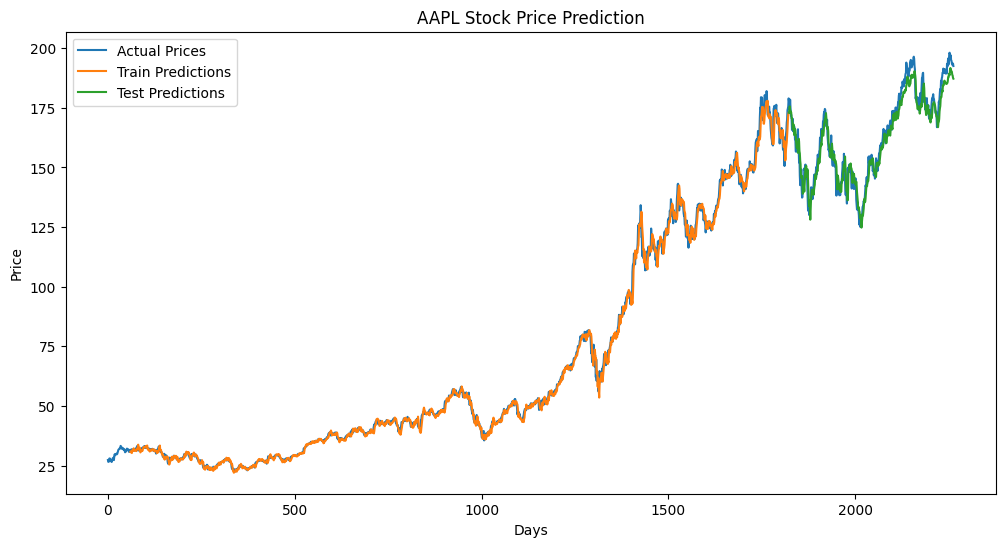

In [7]:
# Evaluate and Visualize Predictions
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform predictions and actual values
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(len(data)), data['Close'], label='Actual Prices')
plt.plot(range(seq_length, seq_length + len(train_pred)), train_pred, label='Train Predictions')
plt.plot(range(seq_length + len(train_pred), len(data)), test_pred, label='Test Predictions')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.show()
